<a href="https://colab.research.google.com/github/sangttruong/IncomeVis/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing Income Inequality in the United Stated

Author: Sang Truong and Dr. Humberto Barreto, Department of Economics and Management

DePauw University, Greencastle, Indiana, 46135, Summer 2019


This notebook records all important steps to transform, compress, and visualize raw from IPUMS-CPS.

Before getting start, we import some important libraries, such as pandas for data manipulation and analysis, numpy for scientific computing, sklearn for statistical analysis. We also mount Google Drive to Google Colab so that all of analyses are conduct online.

In [0]:
import pandas as pd
import numpy as np
import json

from collections import OrderedDict
from google.colab import drive
from sklearn.linear_model import LinearRegression

drive.mount('/content/gdrive')
in_path = 'gdrive/My Drive/Colab Notebooks/IncomeVis2019/input/'
out_path = 'gdrive/My Drive/Colab Notebooks/IncomeVis2019/output/'

# Section 1. Deflator generator

100 dollars last 10 years is not equal to 100 dollars today due to inflation. To compare incomes overtime, we need to converge them to the same unit (specifically, in this analysi we use 2018 dollars). We achieve this goal by using Consumer Price Index (CPI) deflator.

However, even after account for inflation, it still does not make sense to compare income of a person in Indiana with a person in California, simply because it is significantly more expensive to live in California. To account for this difference, we deflate income with Cost of Living Index (COLI) deflator.

The final deflator is the product of 2 above index. 



## 1.1. Cost Of Living Index

COLI raw data can be downloaded from IPUMS-USA: https://usa.ipums.org/usa. Below, we first 10 rows of our raw data. Before 2000, the we have the data for every 10 years. After 200, we have the data for every year.

In [6]:
# Import raw COLI
raw_COLI = pd.read_csv(in_path + "raw_COLI.csv")

raw_COLI.head(10)

,YEAR,HHWT,STATEFIP,RENTGRS,RELATE,RELATED
0,1970,100,25,168,1,101
1,1970,100,25,168,2,201
2,1970,100,25,168,3,301
3,1970,100,25,168,3,301
4,1970,100,25,168,3,301
5,1970,100,25,0,1,101
6,1970,100,25,0,3,301
7,1970,100,25,133,1,101
8,1970,100,25,133,2,201
9,1970,100,25,133,3,301


We generate list of states code that we will work with. **stateList** is derived from variable STATEFIP from IPUMS. We also generate a list of years in which the data was available (**yearList**). We manually input these lists because they are not evenly spaced.

In [0]:
# Generate constants for COLI
stateList = [1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,
             28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,
             50,51,53,54,55,56]

yearList = [1970, 1980, 1990, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
            2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

Our unit of analysis is household. The unit of raw_COLI dataframe is person. Therefore, we only use information of household head (RELATE = 1) for further analysis. In addition, we select individual with positive monthly gross rent (RENTGRS) for further analysis.

In [0]:
# Eliminate RENTGRS = 0
raw_COLI = raw_COLI[raw_COLI.RENTGRS > 0]

# Select the household head
raw_COLI = raw_COLI[raw_COLI.RELATE == 1]
raw_COLI = raw_COLI.drop(columns = ['RELATE'])

We store the final COLI deflator in a dataframe call COLI. The column of this dataframe are years in yearList, and its rows are states in stateList. We will fill out this dataframe column by column (in other words, year by year). In each year, COLI of a state is the medium of gross rent for that state.

In [0]:
# Generate COLI grid
COLI = pd.DataFrame(columns = yearList, index = stateList)

# Iterate through each year in yearList
for y in yearList:
  year = raw_COLI[raw_COLI.YEAR == y]

  # Iterate through each state
  COLI[y] = year.groupby(year['STATEFIP'])['RENTGRS'].median()

# Compute COLI
COLI = 0.44*COLI + 0.56

COLI = COLI.T

We decide to use medium instead of mean as a way to summarize data for each state in each year because the data contains a large amount of outlier as illustrated in the boxplot below (for STATEFIP = 1, for example). 

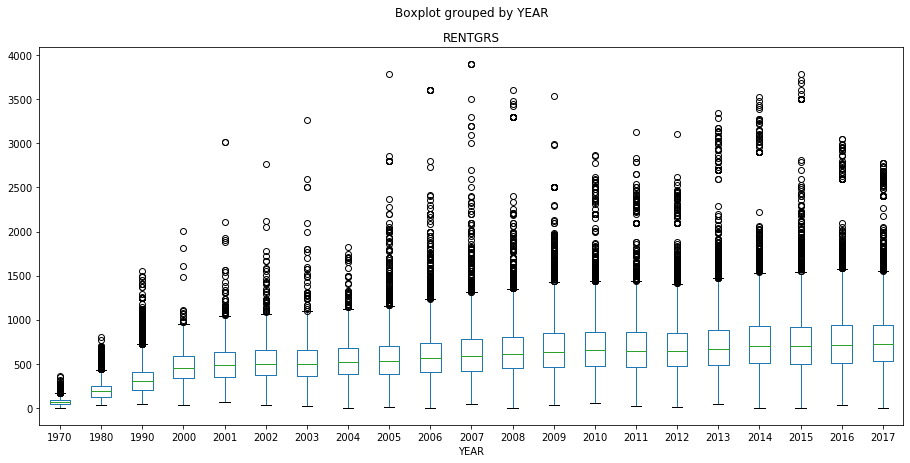

In [33]:
state1 = raw_COLI[raw_COLI.STATEFIP == 1]
state1.boxplot(column='RENTGRS', by = 'YEAR', grid = False, figsize = (15,7))

In [22]:
state1

,YEAR,RENTGRS
1295188,1970,0
1295189,1970,0
1295190,1970,0
1295191,1970,0
1295192,1970,0
...,...,...
67679730,2017,0
67679731,2017,0
67679732,2017,0
67679733,2017,0


In [0]:
# Generate regression grid
reg = pd.DataFrame(index = stateList, columns = [['Coefficient', 'Intercept', 'Rsquared']])

# Generate list of years that are missed
predList = [1978,1979,1981,1982,1983,1984,1985,1986,1987,1988,
            1989,1991,1992,1993,1994,1995,1996,1997,1998,1999, 2018]

# Generate COLI prediction grid
predCOLI = pd.DataFrame(columns = stateList, index = predList)

# Convert predList and yearList to 2D array for sklearn
predList2D = np.reshape(predList, (-1,1))
yearList2D = np.reshape(yearList, (-1,1))

In [0]:
# Create instance of class
model = LinearRegression()

# Regress deflator on year
for i in stateList:
  model.fit(yearList2D, COLI[i])
  reg.loc[i, 'Coefficient'] = model.coef_.item(0)
  reg.loc[i, 'Intercept'] = model.intercept_
  reg.loc[i, 'Rsquared'] = model.score(yearList2D, COLI[i])
  predCOLI[i] = model.predict(predList2D)

# Concatinate available data and inferred data
COLI = pd.concat([COLI, predCOLI])
COLI = COLI.sort_index()

In [0]:
# Compute average COLI
avgCOLI = COLI.mean(axis = 1)
avgCOLI = pd.DataFrame(avgCOLI)
avgCOLI = avgCOLI.rename(columns = {0: "AVG_COLI"})

In [0]:
# Normalize COLI by average COLI by year
for y in range(1978, 2019): 
  COLI.loc[y] = COLI.loc[y]/avgCOLI.loc[y,'AVG_COLI']

# Drop year 1970
COLI.drop(index = 1970, inplace = True )

## 1.2. Consumer Price Index

In [0]:
# Import CPI
CPI = pd.read_csv(in_path + "CPI.csv", index_col="YEAR")
CPI.drop_duplicates(keep='first', inplace=True)
CPI.dropna(inplace=True)
CPI.rename(columns = {'CPI99':'PriceIndex'}, inplace = True)

# Convert price index to 2018 dollar from 1999 dollar
CPI = CPI/CPI.loc[2018, 'PriceIndex']

# Compute CPI by inverting price index of previous year
CPI["CPI"] = np.nan
# (Not compute the very first CPI because the price index is not available)
for i in CPI.index[1:len(CPI.index)]:
  CPI.loc[i, 'CPI'] = 1/ CPI.loc[i-1, 'PriceIndex']

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## 1.3. Deflator = COLI * CPI

In [0]:
# Generate final deflator dataframes
deflator = pd.DataFrame(data = COLI, index = range(1978, 2019), columns = stateList) 

# Transpose deflator
deflator = deflator.T

# Compute deflator from COLI and CPI
for i in range(1978, 2019):
  deflator[i] = deflator[i] * CPI.loc[i-1, 'CPI']

In [0]:
# Flatten deflator matrix
flat = np.matrix(deflator).flatten()
flat = pd.DataFrame(flat)
flat = flat.T
flat.rename(columns = {0: 'DEFLATOR'}, inplace = True)

# Index YEAR
year_Deflator = np.arange(1978, 2019, 1)
year_Deflator_multiply = np.tile(year_Deflator,len(stateList))
flat['YEAR'] = year_Deflator_multiply

# Index STATEFIP
stateDeflator_multiply = np.tile(stateList,len(year_Deflator))
stateDeflator_multiply.sort()
flat['STATEFIP'] = stateDeflator_multiply

# Section 2. Data processor

## 2.1. Data cleaning

In [0]:
# Import raw data
raw = pd.read_csv(in_path + "raw.csv")

# Select data with HFLAG != 1 and then drop HFLAG
raw = raw[raw.HFLAG != 1]
raw = raw.drop(columns = ['HFLAG'])
# Generate size
raw["SIZE"] = np.nan

raw.loc[raw["PERNUM"] == 1, "SIZE"] = 1
raw.loc[(raw["PERNUM"] != 1) & (raw["AGE"] > 16), "SIZE"] = 0.7
raw.loc[(raw["PERNUM"] != 1) & (raw["AGE"] <= 16), "SIZE"] = 0.5

# Generate family ID
raw["FAMID"] = np.nan
length = sum(raw.loc[raw['PERNUM'] == 1, 'PERNUM'])
raw.loc[raw['PERNUM'] == 1, 'FAMID'] = np.arange(length)
raw = raw.fillna(method='pad')

# Generate effective size
effsize = raw.groupby(['FAMID'])['SIZE'].agg('sum').reset_index()

# Merge effective size with raw
raw = pd.merge(raw, effsize, on = ["FAMID"])

# Rename 'sizes'
raw = raw.rename(columns={'SIZE_x': 'SIZE', 'SIZE_y': 'EFFSIZE'})

# Eliminate observations that has PERNUM != 1
raw = raw[raw.PERNUM == 1]
raw = raw.drop(columns = ['PERNUM'])

In [0]:
# Merge raw anf flatten deflator on YEAR and STATEFIP
raw = pd.merge(raw, flat, on = ["YEAR", "STATEFIP"])

# Generate deflated household income column
raw["DHHINCOME"] = np.nan
raw.DHHINCOME = raw.HHINCOME/(raw.DEFLATOR*raw.EFFSIZE)

# Generate cumulative weight and percentage
raw["CUMWT"] = np.nan
raw["PERCENT"] = np.nan

# Import formating components
codeFirst_oneYear = pd.read_csv(in_path + "codeFirst_oneYear.csv", index_col = 0)
codeThird_oneYear = pd.read_csv(in_path + "codeThird_oneYear.csv", index_col = 0)

# Create constant
stateList = [1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,
             28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,
             50,51,53,54,55,56]

d_ile = [0.05,0.15,0.25,0.35,0.45,0.50,0.55,0.65,0.75,0.85,0.95]

p_ile = [0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,
          0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,
          0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,
          0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,
          0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,
          0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,
          0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]

## 2.2 Generate k-ile graphs for each year

In [0]:
# Choose k: decile ('d') or percentile ('p')
k = 'd'

In [0]:
if (k == 'd'):
  k_ile = d_ile

  elif (k == 'p'):
    k_ile = p_ile

In [0]:
for y in range(1978, 2019):
  # Generate year dataframe
  year = raw[raw.YEAR == y]

  # Generate result grid, decile-column
  result = pd.DataFrame(data=None, index=np.arange(0,11,1), columns=stateList)

  # Iterate through each state
  c = 0
  for i in stateList:
    # Generate state dataframe
    state = year[year.STATEFIP == i]
    state = state.reset_index(drop = True)

    # Sort state dataframe by DHHINCOME
    state = state.sort_values('DHHINCOME')
    
    # Calculate cumulated weight and Percentage
    state.CUMWT = state.ASECWTH.cumsum()
    state.PERCENT = state.CUMWT/(state.ASECWTH.sum())
    
    # Calculate decile
    r = 0
    for d in decile:
      result.iloc[r,c] = state.loc[state['PERCENT'] <= d, 'DHHINCOME'].max()
      r = r + 1
    c = c + 1

  # Transpose result table: column-decile
  result = result.transpose()

  # Type casting result.index (type casting STATEFIP) to integer
  result.index = result.index.map(int)

  # Merge state dataframe with code dataframe
  result = pd.merge(codeFirst_oneYear, result, left_index = True, right_index = True)
  result = pd.merge(result, codeThird_oneYear, left_index = True, right_index = True)

  # Compute state population and normalized state population
  result["POP"] = np.nan
  result.POP = year.groupby(['STATEFIP'])['ASECWT'].agg('sum')

  result["NORMPOP"] = np.nan
  result.NORMPOP = round(result.POP/(result.POP.min()))

  # Replicate each state's dataline with its respected replication number
  for i in stateList:
    rep = result.loc[i,'NORMPOP'] - 1
    rep = int(rep)
    line = result[result.index == i].copy()
    line.name = i
    line.loc[i, 'Label'] = ''
    for i in range(0,rep): result = result.append(line)

  # Drop population and normalized population
  result = result.drop(columns = ['POP', 'NORMPOP'])

  # Sort the result by median
  result = result.sort_values(by = [5], ascending = True)

  # Rename index column and role
  result = result.rename(index = str, columns = {0: "5p", 1: "15p", 2: "25p", 3: "35p", 4: "45p", 5: "50p",
                                                6: "55p", 7: "65p", 8: "75p", 9: "85p", 10: "95p"})

  # Export result grid  
  result.to_csv(out_path + 'year_d/' + str(y) + '_d.csv')

  # Convert dataframe to JSON
  result = result.to_json(orient = 'records')
  result = json.loads(result, object_pairs_hook = OrderedDict)

  # Make JSON format readable
  result = json.dumps(result, indent = 4, sort_keys = False)

  # Save JSON to text format
  with open(out_path + 'year_d/' + str(y) + '_d.txt', 'w') as f:
    f.writelines(result)

  # Glue data with html environment
  filenames = [in_path + 'first_d_oneYear.txt', out_path + 'year_d/' + str(y) + '_d.txt',
              in_path + 'third.txt']
  with open(out_path + 'year_d/' + str(y) + '_d.html', 'w') as outfile:
    for i in filenames:
      with open (i) as infile:
        outfile.write(infile.read())

In [0]:
STOP here

## year_p

There are 4 differences between d_files and p_files:

*   Deciles
*   Loop to construct result grid sheet (0 to 98 instead of 0 to 11)
*   Use first_p instead of first_d (look at pCodeGenerator excel file for detail about p_code generator)
*   out_path: use year_p_gsp_data instead of year_d_gsp_data
*   Change name when export data

In [0]:
import pandas as pd
import json
from collections import OrderedDict
from google.colab import drive
drive.mount('/content/gdrive')
in_path = 'gdrive/My Drive/Colab Notebooks/code/'
out_path = 'gdrive/My Drive/Colab Notebooks/oneYear/year_p/'

# Import raw data state codes, color codes, and deflator
raw = pd.read_csv(in_path + "raw.csv")
codeFirst_oneYear = pd.read_csv(in_path + "codeFirst_oneYear.csv", index_col = 0)
codeThird_oneYear = pd.read_csv(in_path + "codeThird_oneYear.csv", index_col = 0)
deflator = pd.read_csv(in_path + "COLI.csv")

# Generate constants
stateList = [1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,
             28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,
             50,51,53,54,55,56]
decile = [0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,
          0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,
          0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,
          0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,
          0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,
          0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,
          0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
value = ['','','','','','','','','','','','','','','','','','','','','','',
         '','','','','','','','','','','','','','','','','','','','','','',
         '','','','','','','']

# Iterate through each year
for y in range(1978, 1979):
  
  # Generate result grid, decile-column
  result = pd.DataFrame(columns = stateList)
  for i in range(0, 98): result.loc[i] = value
  
  # Generate year dataframe
  year = raw[raw.YEAR == y]
  
  # Eliminate observations that has PERNUM != 1
  person = year[year.PERNUM == 1]
  
  # Merge 2 file: for raw, every row that has STATEFIP and YEAR match with 
  # that row in deflator will get the same deflator value.
  person = pd.merge(person, deflator, on = ["YEAR","STATEFIP"])
  
  # Rearrange culumns order
  person = person[['YEAR', 'ASECWTH', 'STATEFIP', 'HHINCOME', 'PERNUM', 
                   'ASECWT','DEFLATOR','SEX','RACE','HISPAN','EDUC']]
  
  # Generate deflated household income column
  person.insert(7, 'DHHINCOME', '')
  
  # Iterate through the entire 'person' to calculate deflated income
  for i in range (0, len(person)):
    person.iloc[i, 7] = person.iloc[i, 3]/person.iloc[i, 6]
  
  # Sort the remainded observation by STATEFIP
  person.sort_values('STATEFIP')
  
  # Iterate through each state
  c = 0
  for i in stateList:
    # Generate state dataframe
    state = person[person.STATEFIP == i]
    
    # Sort state dataframe by HHINCOME
    state = state.sort_values('HHINCOME')
    
    # Calculate cumulated weight and Percentage
    state.insert(8, 'CUMWT', '')
    state.insert(9, 'PERCENT', '')
    state.iloc[0, 8] = state.iloc[0, 1]
    state.iloc[0, 9] = state.iloc[0, 8]/(state.sum().ASECWT)
    for i in range (1, len(state)):
      state.iloc[i, 8] = state.iloc[i-1, 8] + state.iloc[i, 1]
      state.iloc[i, 9] = state.iloc[i, 8]/(state.sum().ASECWT)
    
    # Calculate decile
    r = 0
    for d in decile:
      for i in range (0, len(state)):
        if (d < state.iloc[i, 9]):
          result.iloc[r,c] = state.iloc[i, 7]
          r = r + 1
          break
    c = c + 1
    
  # Transpose result table: column-decile
  result = result.transpose()

  # Type casting result.index (type casting STATEFIP) to integer
  result.index = result.index.map(int)

  # Merge state dataframe with code dataframe
  result = pd.merge(codeFirst_oneYear, result, left_index = True, right_index = True)
  result = pd.merge(result, codeThird_oneYear, left_index = True, right_index = True)

  result.insert(101, 'POP','')
  r = 0
  for i in stateList:
    state = year[year.STATEFIP == i]
    result.iloc[r, 101] = state.sum().ASECWT
    r = r + 1

  result.insert(102, 'NORMPOP', '')
  for i in range(0, len(result)):
    result.iloc[i, 102] = round(result.iloc[i, 101]/(result['POP'].min()))

  for i in stateList:
    rep = result.loc[int(i),'NORMPOP'] - 1
    rep = int(rep)
    # The following statement need .copy() at the end for explicit reason
    # More information: https://www.dataquest.io/blog/settingwithcopywarning/
    line = result[result.index == i].copy()
    line.name = i
    line.iloc[0, 99] = ''
    for i in range(0,rep): result = result.append(line)
        
  # result.to_csv(out_path+str(y)+'withPop.csv')
  result = result.drop(columns = ['POP', 'NORMPOP'])
      
  # Sort the result by median
  result = result.sort_values(48, ascending = True)

  # Rename index column and role
  result = result.rename(index = str, columns = {0: "2p", 1: "3p", 2: "4p", 3: "5p",
                                                 4: "6p", 5: "7p", 6: "8p", 7: "9p",
                                                 8: "10p", 9: "11p", 10: "12p",
                                                 11: "13p", 12: "14p", 13: "15p",
                                                 14: "16p", 15: "17p", 16: "18p",
                                                 17: "19p", 18: "20p", 19: "21p",
                                                 20: "22p", 21: "23p", 22: "24p",
                                                 23: "25p", 24: "26p", 25: "27p",
                                                 26: "28p", 27: "29p", 28: "30p",
                                                 29: "31p", 30: "32p", 31: "33p",
                                                 32: "34p", 33: "35p", 34: "36p",
                                                 35: "37p", 36: "38p", 37: "39p",
                                                 38: "40p", 39: "41p", 40: "42p",
                                                 41: "43p", 42: "44p", 43: "45p",
                                                 44: "46p", 45: "47p", 46: "48p",
                                                 47: "49p", 48: "50p", 49: "51p",
                                                 50: "52p", 51: "53p", 52: "54p",
                                                 53: "55p", 54: "56p", 55: "57p",
                                                 56: "58p", 57: "59p", 58: "60p",
                                                 59: "61p", 60: "62p", 61: "63p",
                                                 62: "64p", 63: "65p", 64: "66p",
                                                 65: "67p", 66: "68p", 67: "69p",
                                                 68: "70p", 69: "71p", 70: "72p",
                                                 71: "73p", 72: "74p", 73: "75p",
                                                 74: "76p", 75: "77p", 76: "78p",
                                                 77: "79p", 78: "80p", 79: "81p",
                                                 80: "82p", 81: "83p", 82: "84p",
                                                 83: "85p", 84: "86p", 85: "87p",
                                                 86: "88p", 87: "89p", 88: "90p",
                                                 89: "91p", 90: "92p", 91: "93p",
                                                 92: "94p", 93: "95p", 94: "96p",
                                                 95: "97p", 96: "98p", 97: "99p"})
  
  result.to_csv(out_path+str(y) + '_p.csv')

  # Convert dataframe to JSON
  result = result.to_json(orient = 'records')
  result = json.loads(result, object_pairs_hook = OrderedDict)

  # Make JSON format readable
  result = json.dumps(result, indent = 4, sort_keys = False)

  # Save JSON to text format
  with open(out_path + str(y) + '_p.txt', 'w') as f:
    f.writelines(result)

  # Glue data with html environment
  filenames = [in_path + 'first_p_oneYear.txt', out_path + str(y) + '_p.txt',
               in_path + 'third.txt']
  with open(out_path + str(y) + '_p.html', 'w') as outfile:
    for i in filenames:
      with open (i) as infile:
        outfile.write(infile.read())

## state_d

In [0]:
import pandas as pd
import json
from collections import OrderedDict
from google.colab import drive
drive.mount('/content/gdrive')
in_path = 'gdrive/My Drive/Colab Notebooks/code/'
out_path = 'gdrive/My Drive/Colab Notebooks/oneState/state_d/'

# Import raw data state codes, color codes, and deflator
raw = pd.read_csv(in_path + "raw.csv")
codeFirst_oneState = pd.read_csv(in_path + "codeFirst_oneState.csv", index_col = 0)
codeThird_oneState = pd.read_csv(in_path + "codeThird_oneState.csv", index_col = 0)
deflator = pd.read_csv(in_path +"COLI.csv")

# Select data with HFLAG != 1 and then drop HFLAG
raw = raw[raw.HFLAG != 1]
raw = raw.drop(columns = ['HFLAG'])

# Generate constants
stateList = [1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,
             28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,
             50,51,53,54,55,56]

# stateList = [12]

decile = [0.05,0.15,0.25,0.35,0.45,0.50,0.55,0.65,0.75,0.85,0.95]
value = ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
         '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
         '', '', '', '', '']
yearList = [1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
            1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
            2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

# Iterate through each state
for s in stateList:
  
  # Generate result grid, decile-column
  result = pd.DataFrame(columns = yearList)
  for i in range(0, 11): result.loc[i] = value
  
  # Generate state dataframe
  state = raw[raw.STATEFIP == s]

  # Eliminate observations that has PERNUM != 1
  person = state[state.PERNUM == 1]
  
  # Merge 2 file: for raw, every row that has STATEFIP and YEAR match with 
  # that row in deflator will get the same deflator value.
  person = pd.merge(person, deflator, on = ["YEAR","STATEFIP"])
  
  # Rearrange culumns order
  person = person[['YEAR', 'ASECWTH', 'STATEFIP', 'HHINCOME', 'PERNUM', 
                   'ASECWT','DEFLATOR','SEX','RACE','HISPAN','EDUC']]
  
  # Generate deflated household income column
  person.insert(7, 'DHHINCOME', '')
  
  # Iterate through the entire 'person' to calculate deflated income
  for i in range (0, len(person)):
    person.iloc[i, 7] = person.iloc[i, 3]/person.iloc[i, 6]
  
  # Sort the remainded observation by YEAR
  person.sort_values('YEAR')
  
  # Iterate through each year
  c = 0
  for i in yearList:
    # Generate year dataframe
    year = person[person.YEAR == i]
    
    # Sort year dataframe by HHINCOME
    year = year.sort_values('HHINCOME')
    
    # Calculate cumulated weight and Percentage
    year.insert(8, 'CUMWT', '')
    year.insert(9, 'PERCENT', '')
    year.iloc[0, 8] = year.iloc[0, 1]
    year.iloc[0, 9] = year.iloc[0, 8]/(year.sum().ASECWT)
    for i in range (1, len(year)):
      year.iloc[i, 8] = year.iloc[i-1, 8] + year.iloc[i, 1]
      year.iloc[i, 9] = year.iloc[i, 8]/(year.sum().ASECWT)
    
    # Calculate decile
    r = 0
    for d in decile:
      for i in range (0, len(year)):
        if (d < year.iloc[i, 9]):
          result.iloc[r,c] = year.iloc[i, 7]
          r = r + 1
          break
    c = c + 1
    
  # Transpose result table: column-decile
  result = result.transpose()

  # Type casting result.index (type casting YEAR) to integer
  result.index = result.index.map(int)

  # Merge state dataframe with code dataframe
  result = pd.merge(codeFirst_oneState, result, left_index = True, right_index = True)
  result = pd.merge(result, codeThird_oneState, left_index = True, right_index = True)

  result.insert(14, 'POP','')
  r = 0
  for i in yearList:
    year = state[state.YEAR == i]
    result.iloc[r, 14] = year.sum().ASECWT
    r = r + 1

  result.insert(15, 'NORMPOP', '')
  for i in range(0, len(result)):
    result.iloc[i, 15] = round(10*(result.iloc[i, 14])/(result['POP'].min()))
#     result.iloc[i, 15] = result.iloc[i, 14]/(result['POP'].min())
  for i in yearList:
    rep = result.loc[int(i),'NORMPOP'] - 1
    rep = int(rep)
    # The following statement need .copy() at the end for explicit reason
    # More information: https://www.dataquest.io/blog/settingwithcopywarning/
    line = result[result.index == i].copy()
    line.name = i
    # Remove the name of the state (so that the name does not repeat too many time)
    line.iloc[0, 12] = ''
    for i in range(0,rep): result = result.append(line)
        
#   # result.to_csv(out_path+str(y)+'withPop.csv')
  result = result.drop(columns = ['POP', 'NORMPOP'])
      
  # Sort the result by year
  result = result.sort_values("Year", ascending = True)

  # Rename index column and role
  result = result.rename(index = str, columns = {0: "5p", 1: "15p", 2: "25p",
                                                 3: "35p", 4: "45p", 5: "50p",
                                                 6: "55p", 7: "65p", 8: "75p",
                                                 9: "85p", 10: "95p"})
  
  result.to_csv(out_path+str(s) + '_d.csv')

  # Convert dataframe to JSON
  result = result.to_json(orient = 'records')
  result = json.loads(result, object_pairs_hook = OrderedDict)

  # Make JSON format readable
  result = json.dumps(result, indent = 4, sort_keys = False)

  # Save JSON to text format
  with open(out_path + str(s) + '_d.txt', 'w') as f:
    f.writelines(result)

  # Glue data with html environment
  filenames = [in_path + 'first_d_oneState.txt', out_path + str(s) + '_d.txt',
               in_path + 'third.txt']
  with open(out_path + str(s) + '_d.html', 'w') as outfile:
    for i in filenames:
      with open (i) as infile:
        outfile.write(infile.read())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## state_p

In [0]:
import pandas as pd
import json
from collections import OrderedDict
from google.colab import drive
drive.mount('/content/gdrive')
in_path = 'gdrive/My Drive/Colab Notebooks/code/'
out_path = 'gdrive/My Drive/Colab Notebooks/oneState/state_p/'

# Import raw data state codes, color codes, and deflator
raw = pd.read_csv(in_path + "raw.csv")
codeFirst_oneState = pd.read_csv(in_path + "codeFirst_oneState.csv", index_col = 0)
codeThird_oneState = pd.read_csv(in_path + "codeThird_oneState.csv", index_col = 0)
deflator = pd.read_csv(in_path + "COLI.csv")

# Generate constants
stateList = [1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,
             28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,
             50,51,53,54,55,56]

# stateList = [11]

decile = [0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,
          0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,
          0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,
          0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,
          0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,
          0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,
          0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]

value = ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
         '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
         '', '', '', '', '']

yearList = [1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
            1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
            2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

# Iterate through each state
for s in stateList:
  
  # Generate result grid, decile-column
  result = pd.DataFrame(columns = yearList)
  for i in range(0, 98): result.loc[i] = value
  
  # Generate state dataframe
  state = raw[raw.STATEFIP == s]

  # Eliminate observations that has PERNUM != 1
  person = state[state.PERNUM == 1]
  
  # Merge 2 file: for raw, every row that has STATEFIP and YEAR match with 
  # that row in deflator will get the same deflator value.
  person = pd.merge(person, deflator, on = ["YEAR","STATEFIP"])
  
  # Rearrange culumns order
  person = person[['YEAR', 'ASECWTH', 'STATEFIP', 'HHINCOME', 'PERNUM', 
                   'ASECWT','DEFLATOR','SEX','RACE','HISPAN','EDUC']]
  
  # Generate deflated household income column
  person.insert(7, 'DHHINCOME', '')
  
  # Iterate through the entire 'person' to calculate deflated income
  for i in range (0, len(person)):
    person.iloc[i, 7] = person.iloc[i, 3]/person.iloc[i, 6]
  
  # Sort the remainded observation by YEAR
  person.sort_values('YEAR')
  
  # Iterate through each year
  c = 0
  for i in yearList:
    # Generate year dataframe
    year = person[person.YEAR == i]
    
    # Sort year dataframe by HHINCOME
    year = year.sort_values('HHINCOME')
    
    # Calculate cumulated weight and Percentage
    year.insert(8, 'CUMWT', '')
    year.insert(9, 'PERCENT', '')
    year.iloc[0, 8] = year.iloc[0, 1]
    year.iloc[0, 9] = year.iloc[0, 8]/(year.sum().ASECWT)
    for i in range (1, len(year)):
      year.iloc[i, 8] = year.iloc[i-1, 8] + year.iloc[i, 1]
      year.iloc[i, 9] = year.iloc[i, 8]/(year.sum().ASECWT)
    
    # Calculate decile
    r = 0
    for d in decile:
      for i in range (0, len(year)):
        if (d < year.iloc[i, 9]):
          result.iloc[r,c] = year.iloc[i, 7]
          r = r + 1
          break
    c = c + 1
    
  # Transpose result table: column-decile
  result = result.transpose()

  # Type casting result.index (type casting YEAR) to integer
  result.index = result.index.map(int)

  # Merge state dataframe with code dataframe
  result = pd.merge(codeFirst_oneState, result, left_index = True, right_index = True)
  result = pd.merge(result, codeThird_oneState, left_index = True, right_index = True)

  result.insert(14, 'POP','')
  r = 0
  for i in yearList:
    year = state[state.YEAR == i]
    result.iloc[r, 14] = year.sum().ASECWT
    r = r + 1

  result.insert(15, 'NORMPOP', '')
  for i in range(0, len(result)):
    result.iloc[i, 15] = round(result.iloc[i, 14]/(result['POP'].min()))

  for i in yearList:
    rep = result.loc[int(i),'NORMPOP'] - 1
    rep = int(rep)
    # The following statement need .copy() at the end for explicit reason
    # More information: https://www.dataquest.io/blog/settingwithcopywarning/
    line = result[result.index == i].copy()
    line.name = i
    # Remove the name of the state (so that the name does not repeat too many time)
    line.iloc[0, 12] = ''
    for i in range(0,rep): result = result.append(line)
        
#   # result.to_csv(out_path+str(y)+'withPop.csv')
  result = result.drop(columns = ['POP', 'NORMPOP'])
      
  # Sort the result by year
  result = result.sort_values("Year", ascending = True)

  # Rename index column and role
  result = result.rename(index = str, columns = {0: "2p", 1: "3p", 2: "4p", 3: "5p",
                                                 4: "6p", 5: "7p", 6: "8p", 7: "9p",
                                                 8: "10p", 9: "11p", 10: "12p",
                                                 11: "13p", 12: "14p", 13: "15p",
                                                 14: "16p", 15: "17p", 16: "18p",
                                                 17: "19p", 18: "20p", 19: "21p",
                                                 20: "22p", 21: "23p", 22: "24p",
                                                 23: "25p", 24: "26p", 25: "27p",
                                                 26: "28p", 27: "29p", 28: "30p",
                                                 29: "31p", 30: "32p", 31: "33p",
                                                 32: "34p", 33: "35p", 34: "36p",
                                                 35: "37p", 36: "38p", 37: "39p",
                                                 38: "40p", 39: "41p", 40: "42p",
                                                 41: "43p", 42: "44p", 43: "45p",
                                                 44: "46p", 45: "47p", 46: "48p",
                                                 47: "49p", 48: "50p", 49: "51p",
                                                 50: "52p", 51: "53p", 52: "54p",
                                                 53: "55p", 54: "56p", 55: "57p",
                                                 56: "58p", 57: "59p", 58: "60p",
                                                 59: "61p", 60: "62p", 61: "63p",
                                                 62: "64p", 63: "65p", 64: "66p",
                                                 65: "67p", 66: "68p", 67: "69p",
                                                 68: "70p", 69: "71p", 70: "72p",
                                                 71: "73p", 72: "74p", 73: "75p",
                                                 74: "76p", 75: "77p", 76: "78p",
                                                 77: "79p", 78: "80p", 79: "81p",
                                                 80: "82p", 81: "83p", 82: "84p",
                                                 83: "85p", 84: "86p", 85: "87p",
                                                 86: "88p", 87: "89p", 88: "90p",
                                                 89: "91p", 90: "92p", 91: "93p",
                                                 92: "94p", 93: "95p", 94: "96p",
                                                 95: "97p", 96: "98p", 97: "99p"})
  
  result.to_csv(out_path+str(s) + '_p.csv')

  # Convert dataframe to JSON
  result = result.to_json(orient = 'records')
  result = json.loads(result, object_pairs_hook = OrderedDict)

  # Make JSON format readable
  result = json.dumps(result, indent = 4, sort_keys = False)

  # Save JSON to text format
  with open(out_path + str(s) + '_p.txt', 'w') as f:
    f.writelines(result)

  # Glue data with html environment
  filenames = [in_path + 'first_p_oneState.txt', out_path + str(s) + '_p.txt',
               in_path + 'third.txt']
  with open(out_path + str(s) + '_p.html', 'w') as outfile:
    for i in filenames:
      with open (i) as infile:
        outfile.write(infile.read())
        
        #Adjust max income 
        #Adjust household size

References:

*   Color generator: https://www.strangeplanet.fr/work/gradient-generator/index.php

*   AmChart documentation:  https://docs.amcharts.com/3/javascriptcharts/AmGraph

*   Jackblun's graph: https://jackblun.github.io/Globalinc/html/fig_1980.html